In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# one-hot encoder

import numpy as np
from collections import defaultdict

def encode_one_hot(train_set, classes="AGCT"):
    encoder = defaultdict(lambda: np.array([0]*len(classes)))
    pad = 9
        
    for i, _class in enumerate(classes):
        tmp = np.zeros(len(classes))
        tmp[i] = 1
        encoder[_class] = tmp
        
    output = []
    for record in train_set:
        encoded_record = []
        
    output = []
    for record in tqdm(train_set):
        encoded_record = []
        for i in range(pad):
            encoded_record.append([.25, .25, .25, .25])
        for c in record.upper():
            encoded_record.append(encoder[c])
        for i in range(pad):
            encoded_record.append([.25, .25, .25, .25])
            
        output.append(encoded_record)
        
    output = np.array(output)
    
    return output

In [ ]:
# Parsing
import gzip
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from google.colab import files
#myfile = files.upload()
# single dataset version
def get_dataset(path):
    
    dataset =  gzip.open(path, "r")
    output = []    
    for i, record in tqdm(enumerate(dataset)):
        record = record.decode()
        record = record[:-1]
        record = record.split('\t')
        if i != 0:
            output.append(record)
    output = np.array(output).reshape([-1, 4])
    
    return encode_one_hot(output[:, 2]), np.array([int(i) for i in output[:, 3]]).flatten()

x1, y1 = get_dataset("/content/drive/Shareddrives/GP/Aptamer/data/DeepBind/Alx1_DBD_TAAAGC20NCG_3_Z_A.seq.gz")
x2, y2 = get_dataset("/content/drive/Shareddrives/GP/Aptamer/data/DeepBind/Alx1_DBD_TAAAGC20NCG_3_Z_B.seq.gz")
x = np.append(x1, x2, axis=0)
y = np.append(y1, y2, axis=0)

train_x, temp_x, train_y, temp_y = train_test_split(x, y, test_size = 0.4, random_state=112)
valid_x, test_x, valid_y, test_y = train_test_split(temp_x, temp_y, test_size = 0.5, random_state=112)

del(y)
del(temp_x, temp_y)

print(train_x.shape)
print(train_y.shape)

print(valid_x.shape)
print(valid_y.shape)

print(test_x.shape)
print(test_y.shape)

128013it [00:00, 168015.97it/s]
100%|██████████| 128012/128012 [00:02<00:00, 47142.37it/s]
255509it [00:01, 169119.80it/s]
100%|██████████| 255508/255508 [00:05<00:00, 45989.94it/s]


(230112, 38, 4)
(230112,)
(76704, 38, 4)
(76704,)
(76704, 38, 4)
(76704,)


In [ ]:
# train
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Conv1D, ReLU, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy
from tensorflow.keras import backend as K

K.clear_session()
epoch = 10
l2_rate = 1e-5
lr = 0.001
batch_size = 32

model = Sequential()
#Conv
model.add(Conv1D(input_shape=train_x.shape[1:], 
                 filters=16, kernel_size=10, strides=1, 
                 kernel_regularizer=regularizers.l2(l2_rate)))
#Relu 활성함수
model.add(ReLU())
#Pooling
model.add(MaxPooling1D(pool_size=29))
model.add(Flatten())
#MLP
model.add(Dense(32, kernel_regularizer=regularizers.l2(l2_rate)))
model.add(ReLU())
# 드롭
model.add(Dropout(rate=0.3))
# Softmax 정규화
model.add(Dense(1, activation = 'sigmoid', kernel_regularizer=regularizers.l2(l2_rate)))

adam = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[AUC(),'accuracy', Precision(), Recall()])
model.summary()

history = model.fit(train_x, train_y, 
                    validation_data=(valid_x, valid_y), 
                    batch_size=batch_size, epochs=epoch, shuffle=True, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 16)            656       
_________________________________________________________________
re_lu (ReLU)                 (None, 29, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

In [ ]:
result = model.evaluate(test_x, test_y, batch_size=32)

2397/2397 [==============================] - 13s 5ms/step - loss: 0.2057 - auc: 0.9707 - accuracy: 0.9170 - precision: 0.9277 - recall: 0.9495


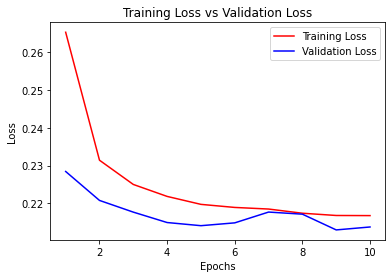

In [ ]:
# graph
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save("./CNN_Final_Alx1.h5")

In [ ]:
#onehot_decoder
def onehot_decoder(seq, word=['A','G','C','T']):
    out = ""
    
    for i in range(9, 29):
        arg = np.argmax(seq[i])
        out += word[arg]
    out+="/"
        
    return out

In [ ]:
#Genetic Algorithm
 
#Initialize
def init():
  pool = []
  for i in range(30):   #유전자풀은 30개, 랜덤으로 초기화함
    seq = []
    for i in range(9):
        seq.append([.25, .25, .25, .25])
    for i in range(20):
        acid = [0, 0, 0, 0]
        n = np.random.randint(0,4)
        acid[n] = 1
        seq.append(acid)
    for i in range(9):
        seq.append([.25, .25, .25, .25])
    pool.append(seq)
  return np.array(pool)
 
#fitness
def fitness(model, pool):
  scores = [0]*30
  for i in range(30):
    seq = np.array(pool[i]).reshape(1,38,4)
    proba = model.predict(seq)
    scores[i] = proba[0][0]
  
  return scores
 
#selection
def selection(pool, scores):
  temp = []
  while len(temp) < 4:  #적합도가 가장 높은 4개의 유전자를 부모로 선정
    index = np.argmax(scores)
    if pool[index] not in temp:
      temp.append(pool[index])
    del scores[index]
    del pool[index]
 
  p1 = temp[0][:] #4개의 부모 유전자
  p2 = temp[1][:]
  p3 = temp[2][:]
  p4 = temp[3][:]
  x = np.random.randint(9,29) #교차 위치 선정
  c1 = p1[:x] + p2[x:] #자식 유전자 생성
  c2 = p2[:x] + p1[x:]
  x = np.random.randint(9,29)
  c3 = p3[:x] + p4[x:]
  c4 = p4[:x] + p3[x:]
  temp.append(c1)
  temp.append(c2)
  temp.append(c3)
  temp.append(c4)
 
  n = np.random.randint(10,19)  #부모 및 자식의 돌연변이 갯수 선정
  for i in range(n):
    index = np.random.randint(0,8)  #오리지날 부모 및 자식 중 하나 선택
    temp_seq = temp[index][:]
    pos_a = np.random.randint(9,29) #돌연변이 시작위치 선정
    pos_b = np.random.randint(pos_a,29) #돌연변이 끝 위치 선정
    for j in range(pos_a, pos_b+1): #pos_a 부터 pos_b까지의 모든 아미노산을 돌연변이 시킴
      temp_acid = [0, 0, 0, 0]
      r = np.random.randint(0,4)  #돌연변이 값 (A,G,T,C 중 하나) 선정
      temp_acid[r] = 1
      temp_seq[j] = temp_acid[:]
 
    temp.append(temp_seq)
 
  for i in range(22-n): #부모와 자식, 돌연변이 외 나머지는 완전 무작위로 sequence를 생성
    seq = []
    for i in range(9):
        seq.append([.25, .25, .25, .25])
    for i in range(20):
        acid = [0, 0, 0, 0]
        n = np.random.randint(0,4)
        acid[n] = 1
        seq.append(acid)
    for i in range(9):
        seq.append([.25, .25, .25, .25])

    temp.append(seq)
 
  return np.array(temp)

In [ ]:
pool = init()
for i in tqdm(range(50)):
  scores = fitness(model, pool)
  index = np.argmax(scores)
  decode_seq = onehot_decoder(pool[index])
  print(f'max scores sequence : {decode_seq}')
  pool = selection(pool.tolist(), scores)[:]
 
scores = fitness(model, pool)

  2%|▏         | 1/50 [00:01<01:22,  1.68s/it]

max scores sequence : TGGGTAACTGCCCGACAGAC/


  4%|▍         | 2/50 [00:03<01:16,  1.59s/it]

max scores sequence : TGACGTGGCTCAGGTCTCAG/


  6%|▌         | 3/50 [00:04<01:12,  1.55s/it]

max scores sequence : TGAGCTGTCCTGAGTGATGT/


  8%|▊         | 4/50 [00:06<01:10,  1.53s/it]

max scores sequence : TGAGCTGTCCTGAGTGATGT/


 10%|█         | 5/50 [00:07<01:10,  1.56s/it]

max scores sequence : TGAGCTGTCCTGAGTGATGT/


 12%|█▏        | 6/50 [00:09<01:07,  1.53s/it]

max scores sequence : TGACGTGTCCTGAGTGATGT/


 14%|█▍        | 7/50 [00:10<01:05,  1.53s/it]

max scores sequence : TGACGTGTCCTGAGTGAATT/


 16%|█▌        | 8/50 [00:12<01:03,  1.51s/it]

max scores sequence : TGACGTGTCCTGACTGATGT/


 18%|█▊        | 9/50 [00:13<01:02,  1.52s/it]

max scores sequence : TGACGTGTCCTGACTGATGT/


 20%|██        | 10/50 [00:15<01:00,  1.51s/it]

max scores sequence : TGACGTGTCCTGACTGATGT/


 22%|██▏       | 11/50 [00:16<00:58,  1.50s/it]

max scores sequence : TGACGTGTCCTGAGCTAATT/


 24%|██▍       | 12/50 [00:18<00:57,  1.50s/it]

max scores sequence : AACTTTAATCGCATTAACCC/


 26%|██▌       | 13/50 [00:19<00:55,  1.51s/it]

max scores sequence : AACTTTAATCGCATTAACCC/


 28%|██▊       | 14/50 [00:21<00:53,  1.50s/it]

max scores sequence : AACTTTAATCGCATTAACCC/


 30%|███       | 15/50 [00:22<00:53,  1.52s/it]

max scores sequence : CACTTTAATCGCATTAACCC/


 32%|███▏      | 16/50 [00:24<00:51,  1.52s/it]

max scores sequence : CACTTTAATCGCATTAACCC/


 34%|███▍      | 17/50 [00:25<00:50,  1.52s/it]

max scores sequence : CACTTTAATCGCATTAACCC/


 36%|███▌      | 18/50 [00:27<00:48,  1.51s/it]

max scores sequence : AACCCTAATCGCATTAACCC/


 38%|███▊      | 19/50 [00:28<00:46,  1.50s/it]

max scores sequence : AACCCTAATCGCATTAACCC/


 40%|████      | 20/50 [00:30<00:44,  1.49s/it]

max scores sequence : AACCCTAATCGCATTAAGTC/


 42%|████▏     | 21/50 [00:31<00:43,  1.50s/it]

max scores sequence : AACCCTAATCGCATTAAGTC/


 44%|████▍     | 22/50 [00:33<00:42,  1.52s/it]

max scores sequence : AACTCTAATCGCATTAACGT/


 46%|████▌     | 23/50 [00:34<00:41,  1.52s/it]

max scores sequence : AACTCTAATCGCATTAAGTC/


 48%|████▊     | 24/50 [00:36<00:39,  1.52s/it]

max scores sequence : AACTCTAATCGCATTAAGTC/


 50%|█████     | 25/50 [00:37<00:37,  1.52s/it]

max scores sequence : AACTCTAATCGGATTAAGTC/


 52%|█████▏    | 26/50 [00:39<00:36,  1.51s/it]

max scores sequence : AACTCTAATCGGATTAAGTC/


 54%|█████▍    | 27/50 [00:40<00:34,  1.50s/it]

max scores sequence : AACTCTAATCGGATTAAGTC/


 56%|█████▌    | 28/50 [00:42<00:33,  1.50s/it]

max scores sequence : AACTCTAATCGGATTAATTG/


 58%|█████▊    | 29/50 [00:43<00:31,  1.50s/it]

max scores sequence : AACTCTAATCGGATTAATTG/


 60%|██████    | 30/50 [00:45<00:30,  1.51s/it]

max scores sequence : AACTCTAATCGGATTAATTG/


 62%|██████▏   | 31/50 [00:47<00:28,  1.52s/it]

max scores sequence : AACTCTAATCGGATTAATTA/


 64%|██████▍   | 32/50 [00:48<00:27,  1.52s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 66%|██████▌   | 33/50 [00:50<00:25,  1.52s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 68%|██████▊   | 34/50 [00:51<00:24,  1.51s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 70%|███████   | 35/50 [00:53<00:22,  1.50s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 72%|███████▏  | 36/50 [00:54<00:20,  1.50s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 74%|███████▍  | 37/50 [00:56<00:19,  1.52s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 76%|███████▌  | 38/50 [00:57<00:18,  1.50s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 78%|███████▊  | 39/50 [00:59<00:16,  1.49s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 80%|████████  | 40/50 [01:00<00:14,  1.46s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 82%|████████▏ | 41/50 [01:01<00:13,  1.45s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 84%|████████▍ | 42/50 [01:03<00:11,  1.43s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 86%|████████▌ | 43/50 [01:04<00:10,  1.46s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 88%|████████▊ | 44/50 [01:06<00:08,  1.48s/it]

max scores sequence : CACTCTAATCGGATTAATTA/


 90%|█████████ | 45/50 [01:07<00:07,  1.49s/it]

max scores sequence : CACTCTAATCAGATTAATTA/


 92%|█████████▏| 46/50 [01:09<00:06,  1.50s/it]

max scores sequence : CACTCTAATCAGATTAATTA/


 94%|█████████▍| 47/50 [01:10<00:04,  1.50s/it]

max scores sequence : CACTCTAATCAGATTAATTA/


 96%|█████████▌| 48/50 [01:12<00:02,  1.50s/it]

max scores sequence : CACTCTAATCAGATTAATTA/


 98%|█████████▊| 49/50 [01:13<00:01,  1.50s/it]

max scores sequence : CACTCTAATCAGATTAATTA/


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]

max scores sequence : CACTCTAATCAGATTAATTA/


In [ ]:
import operator

listsum = []
for seq, score in zip(pool, scores):
  listsum.append([score, seq])

listsum = sorted(listsum, key=operator.itemgetter(0), reverse=True)
for score, seq in listsum:
  decode_seq = onehot_decoder(seq)
  padding_encode = encode_one_hot(decode_seq)
  if padding_encode not in x:
    print(f'sequence : {decode_seq} score : {score}')

100%|██████████| 21/21 [00:00<00:00, 12954.90it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


sequence : CACTCTAATCAGATTAGGTC/ score : 0.9997193217277527


100%|██████████| 21/21 [00:00<00:00, 50331.65it/s]


sequence : CACTCTAATCAGATTAGGTC/ score : 0.9997193217277527


100%|██████████| 21/21 [00:00<00:00, 62512.69it/s]


sequence : CACTCTAATCAGATTAGGTC/ score : 0.9997193217277527


100%|██████████| 21/21 [00:00<00:00, 54606.56it/s]


sequence : CACTCTAATCAGATTAATTA/ score : 0.9997084736824036


100%|██████████| 21/21 [00:00<00:00, 68920.49it/s]


sequence : CACTCTAATCGGATTAGGTC/ score : 0.9996604919433594


100%|██████████| 21/21 [00:00<00:00, 1824.06it/s]


sequence : CACTCTAATCGGATTAATTA/ score : 0.9996198415756226


100%|██████████| 21/21 [00:00<00:00, 58720.26it/s]


sequence : CACTCTAATCGGATTAATTA/ score : 0.9996198415756226


100%|██████████| 21/21 [00:00<00:00, 50650.02it/s]


sequence : CACTCTAATCGGATTAATTA/ score : 0.9996198415756226


100%|██████████| 21/21 [00:00<00:00, 68438.53it/s]


sequence : CACTCTAATCGGATTAATTG/ score : 0.9995980858802795


100%|██████████| 21/21 [00:00<00:00, 29837.53it/s]


sequence : CACTCTAATCGGATTAATTG/ score : 0.9995980858802795


100%|██████████| 21/21 [00:00<00:00, 37949.33it/s]


sequence : CACTCTAATCAGATTACCTA/ score : 0.9994151592254639


100%|██████████| 21/21 [00:00<00:00, 65682.61it/s]


sequence : CACTCTAATCAGTTTAATTA/ score : 0.9854442477226257


100%|██████████| 21/21 [00:00<00:00, 70071.90it/s]


sequence : CTAATGGACTGTGACGACGG/ score : 0.9507313370704651


100%|██████████| 21/21 [00:00<00:00, 68226.48it/s]


sequence : CACTCTTGGTTGATTAATTG/ score : 0.9356608986854553


100%|██████████| 21/21 [00:00<00:00, 54844.57it/s]


sequence : CACTCTAATCGGACCGATTA/ score : 0.9331433773040771


100%|██████████| 21/21 [00:00<00:00, 63458.49it/s]


sequence : CACTCTAATCAGACCTAACC/ score : 0.8237344026565552


100%|██████████| 21/21 [00:00<00:00, 70861.13it/s]


sequence : AGCTAGCGTGCGCGACAAGG/ score : 0.726939857006073


100%|██████████| 21/21 [00:00<00:00, 66778.15it/s]


sequence : CACTCTAATCGATTTCATTG/ score : 0.7062515020370483


100%|██████████| 21/21 [00:00<00:00, 66225.85it/s]


sequence : TGTGATGAGATACGACCTGC/ score : 0.675489068031311


100%|██████████| 21/21 [00:00<00:00, 60494.77it/s]


sequence : GAATTGGATATCCGGTTAAT/ score : 0.6447271108627319


100%|██████████| 21/21 [00:00<00:00, 62247.62it/s]


sequence : ACTAAGAAAGAGGTACCGAG/ score : 0.6424591541290283


100%|██████████| 21/21 [00:00<00:00, 69136.88it/s]


sequence : CGCCACTCCTAGACTACCCC/ score : 0.6373695731163025


100%|██████████| 21/21 [00:00<00:00, 68279.37it/s]


sequence : CCTGGCAGCGAGACGTCGCC/ score : 0.6302531957626343


100%|██████████| 21/21 [00:00<00:00, 78154.73it/s]


sequence : TAGACAGACGATGTTTCAAT/ score : 0.5157375931739807


100%|██████████| 21/21 [00:00<00:00, 72914.23it/s]


sequence : GACTCTAGCCCGATTACCTT/ score : 0.5093300342559814


100%|██████████| 21/21 [00:00<00:00, 50679.16it/s]


sequence : CACTCTTAACATGGCCATTA/ score : 0.37534332275390625


100%|██████████| 21/21 [00:00<00:00, 62291.64it/s]


sequence : GTGTTACTAATGACAGAGCT/ score : 0.31660446524620056


100%|██████████| 21/21 [00:00<00:00, 72974.63it/s]


sequence : GCGCGGGATAGCCTGTTTAT/ score : 0.16672144830226898


100%|██████████| 21/21 [00:00<00:00, 81480.47it/s]


sequence : CCAAGCCGGAATTTGAGCAT/ score : 0.11214780062437057


100%|██████████| 21/21 [00:00<00:00, 67858.54it/s]

sequence : CAAGGGCGTTTTTACTATTG/ score : 0.012814541347324848
